# Trabalho de Implementação Final - Redes Neurais

## Tema: Máquinas de Boltzmann
## Abordagem: Máquinas de Boltzmann Restritas como sistema de recomendação de filmes.

### Nome: Alberto Rodrigues Ferreira 
#### Matricula: 391278
### Nome: Daniel de Amaral da Silva
#### Matrícula: 385802

#### *Bibliotecas*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
np.seterr(all = 'ignore') #Silence warnings

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#### *Importando dados e Definindo o número de usuários e filmes*

In [0]:
ratings = pd.read_csv('drive/My Drive/TrabalhoFinalRedesNeurais/ratings.csv', sep = ',', header = None,names=["User","Movie","Rating","Timestamp"])

In [4]:
print(ratings.head())
print(ratings.shape)

   User  Movie  Rating  Timestamp
0     1   1193       5  978300760
1     1    661       3  978302109
2     1    914       3  978301968
3     1   3408       4  978300275
4     1   2355       5  978824291
(1000209, 4)


In [0]:
size_users=len(np.unique(ratings["User"]))
size_movies=max(ratings["Movie"])

In [6]:
size_users

6040

In [7]:
size_movies

3952

#### Definindo conjunto de treino, validação e teste.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(ratings[["Movie","Rating","Timestamp"]], 
                                                    ratings[["User"]], test_size=0.3, 
                                                    random_state=1, 
                                                    stratify = ratings[["User"]])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                   test_size=0.15, random_state=1,
                                                   stratify = y_train)

#### *Lendo o Conjunto de Treino e Teste*

In [9]:
train=np.column_stack((y_train,X_train))[:,:-1]
print(train)

[[4053  529    3]
 [2592 3952    4]
 [4561 2291    3]
 ...
 [2080  904    5]
 [1835 3386    5]
 [3272 3735    4]]


In [10]:
test=np.column_stack((y_test,X_test))[:,:-1]
print(test)

[[4373 2206    4]
 [2059 1485    2]
 [1722 2149    3]
 ...
 [2453 3868    4]
 [3471 1129    4]
 [3031 2141    4]]


In [11]:
val=np.column_stack((y_val,X_val))[:,:-1]
print(val)

[[ 482 2372    3]
 [1449 2186    4]
 [3727 1291    4]
 ...
 [2018 2112    3]
 [2264 1127    4]
 [5269 1222    3]]


#### *Modificando o shape dos dados para o shape do input da RBM*

In [0]:
def convert(data):
    new_data = []
    for id_users in range(1, size_users + 1):
        id_movies = data[:,1][data[:,0] == id_users]
        rating_values = data[:,2][data[:,0] == id_users]
        ratings = -np.ones(size_movies)
        ratings[id_movies - 1] = rating_values
        new_data.append(list(ratings))
    return np.array(new_data)

In [0]:
train = convert(train)
test= convert(test)
val=convert(val)

#### Verificando cada observação do conjunto de treino e teste.

In [14]:
train

array([[ 5., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [15]:
test

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [ 3., -1., -1., ..., -1., -1., -1.]])

In [16]:
val

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [17]:
print(train.shape)
print(test.shape)
print(val.shape)

(6040, 3952)
(6040, 3952)
(6040, 3952)


In [18]:
np.unique(train[0],return_counts=True)

(array([-1.,  3.,  4.,  5.]), array([3921,    4,   18,    9]))

In [19]:
np.unique(val[0],return_counts=True)

(array([-1.,  3.,  4.,  5.]), array([3946,    1,    3,    2]))

In [20]:
np.unique(test[0],return_counts=True)

(array([-1.,  3.,  4.,  5.]), array([3936,    3,    6,    7]))

#### *Transformando em binário, a classificação do filme*

In [0]:
def binarize(dados, k = 3):
    for i in range(dados.shape[0]):
        for j in range(1,6):
            if j >= k:
                dados[i][dados[i] == j] = 1
            else:
                dados[i][dados[i] == j] = 0
    return dados

In [0]:
train = binarize(train)
test = binarize(test)
val = binarize(val)

In [23]:
print(np.unique(train[4,:],return_counts=True))
print(np.unique(test[4,:],return_counts=True))
print(np.unique(val[4,:],return_counts=True))

(array([-1.,  0.,  1.]), array([3834,   33,   85]))
(array([-1.,  0.,  1.]), array([3893,   17,   42]))
(array([-1.,  0.,  1.]), array([3931,    5,   16]))


#### *Classe do Algoritmo RBM*

In [0]:
class RBM():
    def __init__(self, nv, nh, k = 1, nb_epoch = 20, batch_size = 200):
        self.W = np.random.normal(scale = 0.0001, size = (nv, nh))
        self.a = np.zeros(shape = (1, nv))
        self.b = np.zeros(shape = (1, nh))
        self.params_vec = []
        self.size_users = 6040
        self.nb_epoch = nb_epoch
        self.batch_size = batch_size
        self.k2 = k
        
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))
    
    def sample_h(self, x):
        xw = x.dot(self.W)
        activation = xw + np.sum(self.a)
        p_h_given_v = self.sigmoid(activation)
        return p_h_given_v, np.random.binomial(1, p = p_h_given_v)
      
    def sample_v(self, y):
        yw = y.dot(self.W.T)
        activation = yw + np.sum(self.b)
        p_v_given_h = self.sigmoid(activation)
        return p_v_given_h, np.random.binomial(1, p = p_v_given_h)
      
    def update(self, v0, vk, ph0, phk):
        self.W += v0.T.dot(ph0) - vk.T.dot(phk)
        self.a += np.sum(v0 - vk, axis = 0)        
        self.b += np.sum(ph0 - phk, axis = 0)
        
    def fit(self, train, val, plot_loss = False):
      self.train = train
      self.val = val
      tr_loss = []
      vs_loss = []
      for epoch in range(1, self.nb_epoch + 1):
          train_loss = 0
          s = 0
          for id_user in range(0, self.size_users, self.batch_size):
              vk = train[id_user:id_user+self.batch_size,:]
              v0 = train[id_user:id_user+self.batch_size,:]
              ph0, h0 = self.sample_h(v0)
              v1, _ = self.sample_v(h0)
              ph1, _ = self.sample_h(v1)
              for k in range(self.k2):
                  hk = self.sample_h(vk)[1]
                  vk = self.sample_v(hk)[1]
                  vk[v0<0] = v0[v0<0]
              phk = self.sample_h(vk)[0]
              self.update(v0, vk, ph0, phk)
              train_loss += np.mean(np.abs(v0[v0>=0] - vk[v0>=0]))
              s += 1
          # Validating
          val_loss = 0
          for id_user in range(self.size_users):
              v = self.train[id_user:id_user+1,:]
              vt = val[id_user:id_user+1,:]
              if len(vt[vt>=0]) > 0:
                  for k in range(self.k2):
                    h = self.sample_h(v)[1]
                    v = self.sample_v(h)[1]
                  val_loss += np.mean(np.abs(vt[vt>=0] - v[vt>=0]))      
          vs_loss.append(val_loss/self.size_users)
          tr_loss.append(train_loss/s)
          print('epoch: '+str(epoch)+' train_loss: '+str(train_loss/s) + ' val_loss: '+str(val_loss/self.size_users)+'\n')
          self.params_vec.append([self.W, self.a, self.b])
      self.W, self.a, self.b = self.params_vec[np.argmin(vs_loss)]
      if plot_loss == True:
        plt.plot(range(1, self.nb_epoch + 1), tr_loss, label='Treinamento')
        plt.plot(range(1, self.nb_epoch + 1), vs_loss, label='Validação')
        plt.xlabel("Épocas")
        plt.ylabel("Erro")
        plt.ylim((0.12,0.3))
        plt.legend(loc="upper right")
        plt.show()
        
    def test(self, test):
      test_loss = 0
      ts_loss = []
      for id_user in range(self.size_users):
          v = self.train[id_user:id_user+1,:]
          vt = test[id_user:id_user+1,:]
          if len(vt[vt>=0]) > 0:
              for k in range(self.k2):
                h = rbm.sample_h(v)[1]
                prob, v = rbm.sample_v(h)
              test_loss += np.mean(np.abs(vt[vt>=0] - v[vt>=0]))      
      ts_loss.append(test_loss/size_users)
      print('test_loss: '+str(test_loss/size_users))

#### *Hiper-parâmetros*

In [0]:
k2=3

#### *Criação do objeto RBM*

In [0]:
rbm = RBM(nv=size_movies, nh=100, batch_size=200, k = k2, nb_epoch=30)

#### *Treinamento da Rede*

epoch: 1 train_loss: 0.24443650776483927 val_loss: 0.1780769964325002

epoch: 2 train_loss: 0.22951234900468326 val_loss: 0.17437814229474285

epoch: 3 train_loss: 0.229308221290388 val_loss: 0.18237739213035786

epoch: 4 train_loss: 0.2295390910543983 val_loss: 0.17351473153155997

epoch: 5 train_loss: 0.22907591115671164 val_loss: 0.17699066782357742

epoch: 6 train_loss: 0.22956288976191427 val_loss: 0.17636218155302605

epoch: 7 train_loss: 0.22927116709186732 val_loss: 0.18430006419227274

epoch: 8 train_loss: 0.23033130660294343 val_loss: 0.17802909960289634

epoch: 9 train_loss: 0.22919354592501817 val_loss: 0.17756457518985785

epoch: 10 train_loss: 0.23015818330920682 val_loss: 0.1782883216020959

epoch: 11 train_loss: 0.2296609016400695 val_loss: 0.1784320068841577

epoch: 12 train_loss: 0.22916223514444745 val_loss: 0.1772115132538763

epoch: 13 train_loss: 0.22923757725921992 val_loss: 0.17539432900855445

epoch: 14 train_loss: 0.22999839406078645 val_loss: 0.17474949192415

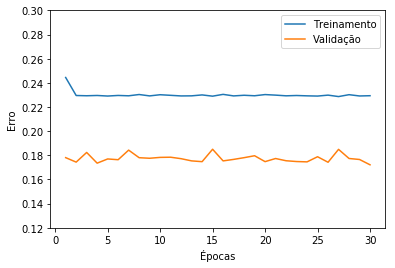

In [27]:
rbm.fit(train, val, plot_loss=True)

In [28]:
rbm.test(test)

test_loss: 0.17015152466061667


#### *Contextualizando*

#### *Recomendação para um determinado array de filmes*

In [0]:
movies = pd.read_csv('drive/My Drive/Boltzmann_Machines/ml-1m/movies.dat', sep = '::', header = None, engine = 'python', encoding = 'latin-1',names=["ID","name_movie","type"])

In [30]:
movies=movies.set_index("ID")
movies.head()

,name_movie,type
ID,,
1,Toy Story (1995),Animation|Children's|Comedy
2,Jumanji (1995),Adventure|Children's|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama
5,Father of the Bride Part II (1995),Comedy


In [31]:
for id_user in range(45):
    v = train[id_user:id_user+1,:]
    vv=val[id_user:id_user+1,:]
    vt = test[id_user:id_user+1,:]
    index_movies_possible_recommended=np.intersect1d(np.intersect1d(np.where(v==-1)[1],np.where(vt==-1)[1]),np.where(vv==-1)[1])
    size_watched_movies=len(np.where(v>=0)[1])+len(np.where(vt>=0)[1])+len(np.where(vv>=0)[1])

    if len(index_movies_possible_recommended)>0:
        for k in range(k2):
          if k==0:
            h = rbm.sample_h(v)[1]
            v = rbm.sample_v(h)
            a=v[0]
            b=v[1]
          else:
            h = rbm.sample_h(b)[1]
            v = rbm.sample_v(h)
            a=v[0]
            b=v[1]
        a=np.where(a[0]==1)[0]
        np.random.shuffle(a)       
        print(id_user+1,"Usuário\n","Filmes Recomendados:","\n","Quantidade de Filmes Assistidos:",
              size_watched_movies,"Quantidades de Filmes Recomendados: ",len(np.intersect1d(np.intersect1d(index_movies_possible_recommended,np.where(b==1)),a[-5:])),"Quantidade De Filmes Total:",size_movies,"\n"
              ,movies.loc[np.intersect1d(np.intersect1d(index_movies_possible_recommended,np.where(b==1)),a[-5:])+1,:],"\n")

1 Usuário
 Filmes Recomendados: 
 Quantidade de Filmes Assistidos: 53 Quantidades de Filmes Recomendados:  5 Quantidade De Filmes Total: 3952 
                              name_movie             type
ID                                                      
1347  Nightmare on Elm Street, A (1984)           Horror
1677               Critical Care (1997)           Comedy
2160             Rosemary's Baby (1968)  Horror|Thriller
2329          American History X (1998)            Drama
2928           Razor's Edge, The (1984)            Drama 

2 Usuário
 Filmes Recomendados: 
 Quantidade de Filmes Assistidos: 129 Quantidades de Filmes Recomendados:  5 Quantidade De Filmes Total: 3952 
                                  name_movie                  type
ID                                                               
279                        My Family (1995)                 Drama
709                 Oliver & Company (1988)  Animation|Children's
1927  All Quiet on the Western Front (1930)   